<a href="https://colab.research.google.com/github/thekarimovmurad/ThesisProjectApp/blob/main/MyThesisApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise
!pip install wordcloud
import pandas as pd
from surprise import Dataset
from surprise import Reader
import matplotlib.pyplot as plt
import numpy as np
import math
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
import random

In [ ]:
# Loading the datasets
ratings = pd.read_csv("ratings.dat", sep='::', header=None, engine='python', encoding='latin1')
ratings = ratings.rename(columns={0: "UserID", 1: "MovieID", 2: "Rating", 3: "Timestamp"})

movies = pd.read_csv("movies.dat", sep='::', header=None, engine='python', encoding='latin1')
movies = movies.rename(columns={0: "MovieID", 1: "Title", 2: "Genres"})

user = pd.read_csv("users.dat", sep='::', header=None, engine='python', encoding='latin1')
user = user.rename(columns={0: "UserID", 1: "Gender", 2: "Age", 3: "Occupation", 4: "Zip-code"})

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [ ]:
ratings.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [ ]:
user.head(5)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [ ]:
movies.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


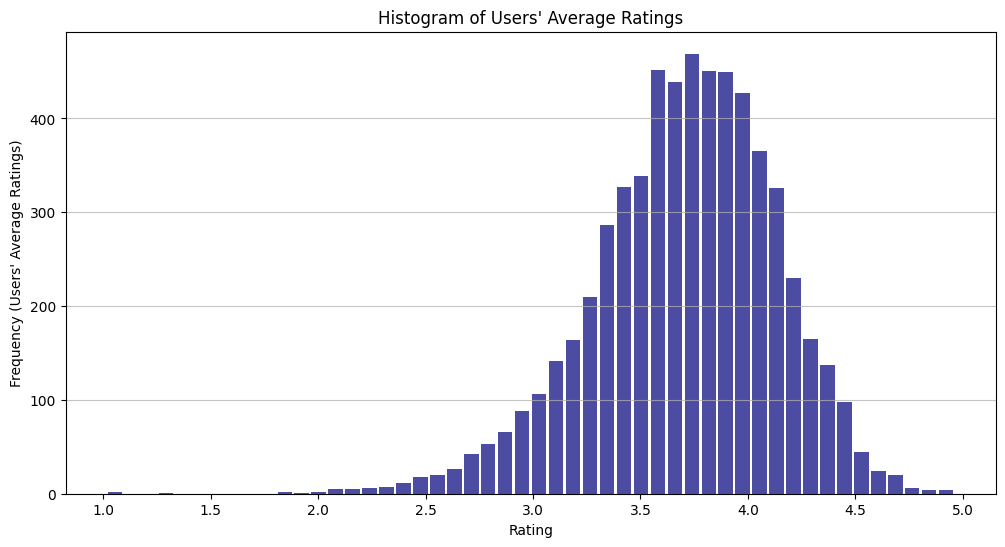

In [ ]:
# plot of users' average rating
plt.hist(ratings.groupby('UserID')['Rating'].mean().tolist(),bins=50, color='#01007d',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Users\' Average Ratings)')
plt.title('Histogram of Users\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_average_rating .png', dpi=100)
plt.show()

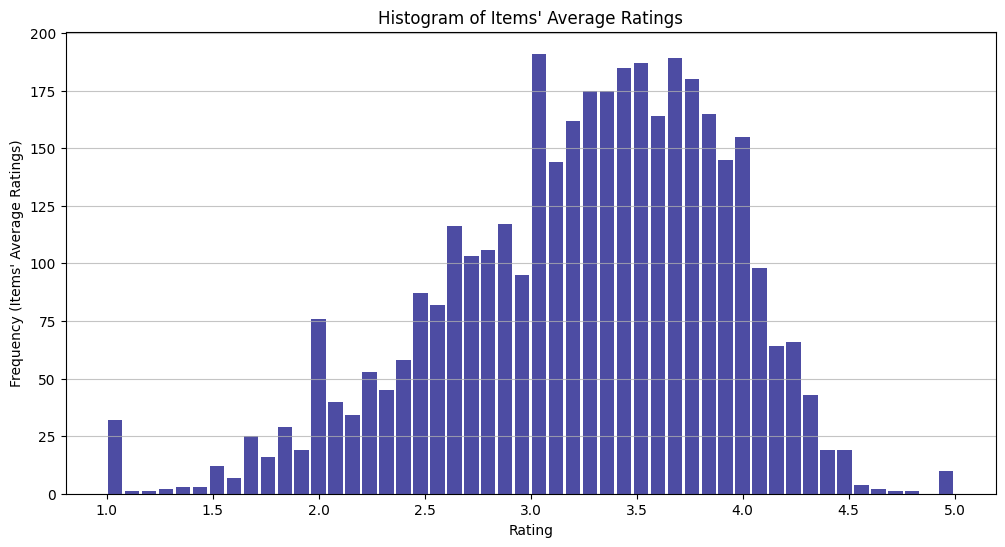

In [ ]:
# plot of items' average rating
plt.hist(ratings.groupby('MovieID')['Rating'].mean().tolist(),bins=50, color='#01007d',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Items\' Average Ratings)')
plt.title('Histogram of Items\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_average_rating.png', dpi=100)
plt.show()

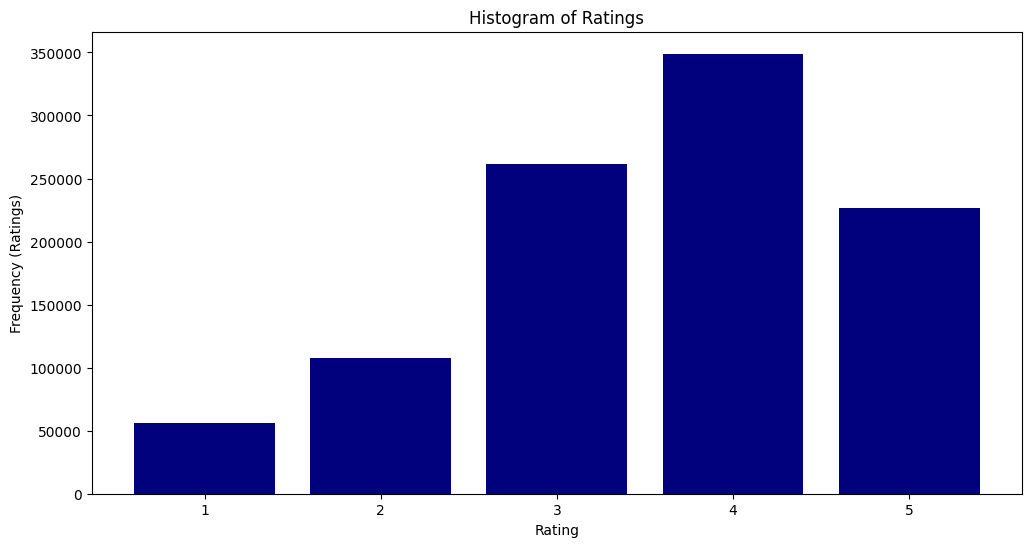

In [ ]:
# plot of ratings
plt.bar(sorted(ratings.Rating.unique()),ratings.groupby('Rating')['UserID'].count(), color='#01007d')
plt.xlabel('Rating')
plt.ylabel('Frequency (Ratings)')
plt.title('Histogram of Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('ratings.png', dpi=100)
plt.show()

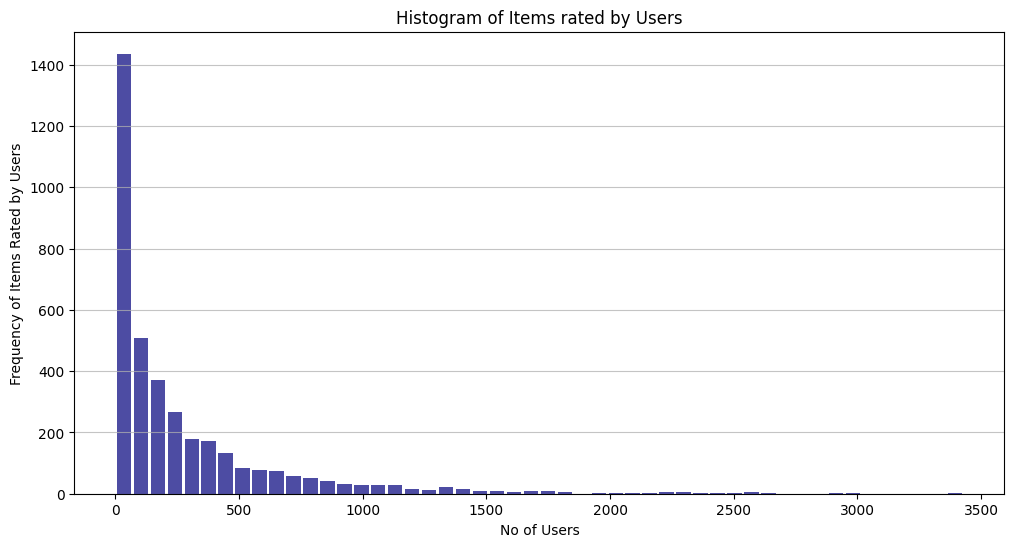

In [ ]:
# plot of histogram of items\' rated by users
plt.hist(ratings.groupby('MovieID')['UserID'].count().tolist(),bins=50, color='#01007d',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No of Users')
plt.ylabel('Frequency of Items Rated by Users')
plt.title('Histogram of Items rated by Users')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_rated_by_users.png', dpi=100)
plt.show()

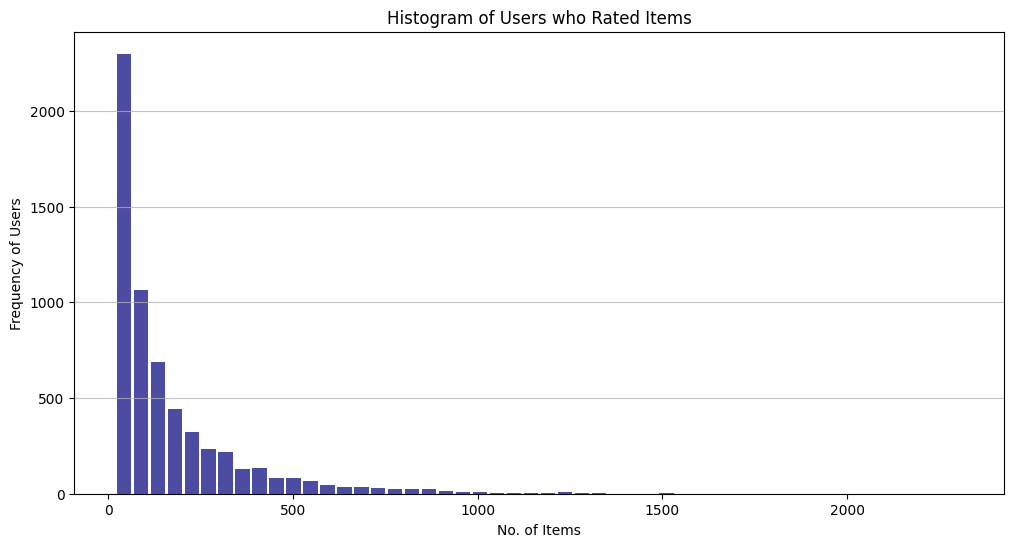

In [ ]:
# plot of items rated by users
plt.hist(ratings.groupby('UserID')['MovieID'].count().tolist(),bins=50, color='#01007d',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No. of Items')
plt.ylabel('Frequency of Users')
plt.title('Histogram of Users who Rated Items')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_who_rated_items.png', dpi=100)
plt.show()

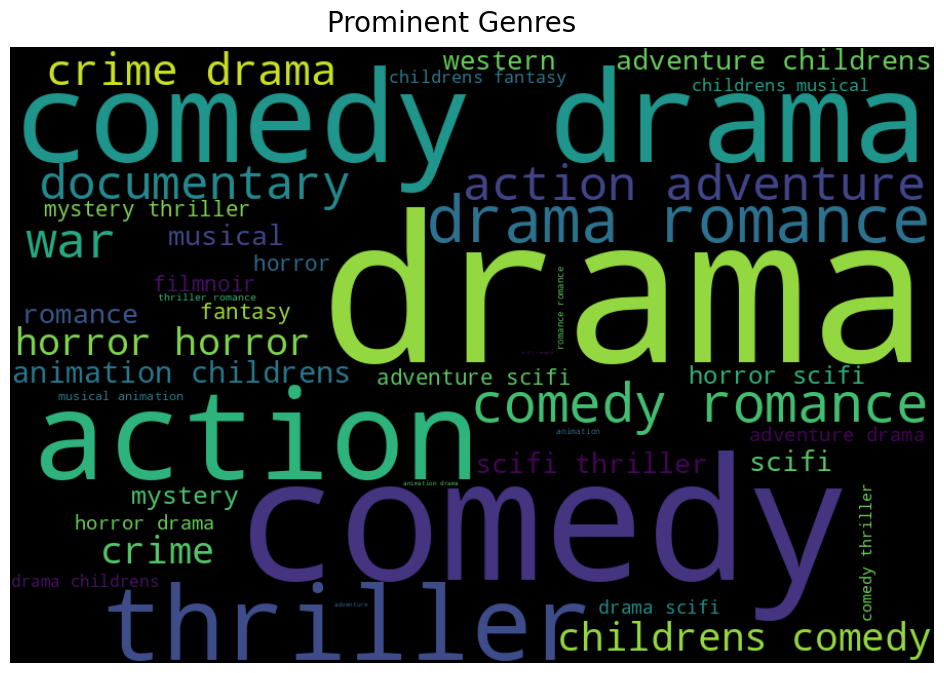

In [ ]:
# wordcloud of genres to show prominent genres
x=movies['Genres'].values.tolist()

all_genres=""
for line in x:
    words=str(line).split("|") #sometimes there were error: 'float' object has no attribute 'split'. That's why cast as a string.
    for word in words:
        word=word.translate(str.maketrans('', '', string.punctuation))
        word=word.lower()
        all_genres=str(all_genres)+" "+str(word)

wordcloud = WordCloud(max_font_size=200, width=900, height=600,collocations=True).generate(all_genres)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figtext(.5,.9,"Prominent Genres", fontsize=20, ha='center')
fig = plt.gcf()
fig.savefig('wordcloud.png', dpi=100)
plt.show()

#Collaborative filtering

In [ ]:
# collaborative filtering using suprise with SVD algorithm
from surprise import Reader, Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings[["UserID", "MovieID", "Rating"]], reader)

# use SDV algorithm
algo = SVD()

# run 5-fold cross-validation
x=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8734  0.8733  0.8737  0.8734  0.8736  0.8735  0.0001  
MAE (testset)     0.6857  0.6859  0.6857  0.6855  0.6862  0.6858  0.0002  
Fit time          26.96   18.42   19.59   19.51   19.11   20.72   3.15    
Test time         2.71    2.33    2.81    3.18    2.65    2.74    0.27    


In [ ]:
# get top 20 recommendation for a user
titles = movies['Title']
indices = pd.Series(movies.index, index=movies['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres
def cf_top_reco(userId):
    cf_df=pd.DataFrame()\

    movie_id_list=ratings['MovieID'].unique().tolist()
    est=[]
    movie_name_list=[]
    actual_score_list=[]
    genre_list=[]
    for i in movie_id_list:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        movie_name = movies[movies.MovieID==i]['Title'].values
        movie_name_list.append(movie_name)
        actual_score =  ratings[(ratings.MovieID==i)&(ratings.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
        genre = movies[movies.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable')
    cf_df['movie_id']=movie_id_list
    cf_df['title']=movie_name_list
    cf_df['estimated_rating']=est
    cf_df['actual_rating']=actual_score_list
    cf_df['genres']=genre_list
    cf_df=cf_df.sort_values(['estimated_rating'], ascending=[False])
    return cf_df

In [ ]:
userid=1
cf_top_reco(userid).head(20)

,movie_id,title,estimated_rating,actual_rating,genres
128,593,"[Silence of the Lambs, The (1991)]",4.979277,[],"[['Drama', 'Thriller']]"
23,527,[Schindler's List (1993)],4.923082,[5],"[['Drama', 'War']]"
2300,2203,[Shadow of a Doubt (1943)],4.888191,[],"[['Film-Noir', 'Thriller']]"
48,2028,[Saving Private Ryan (1998)],4.877610,[5],"[['Action', 'Drama', 'War']]"
167,318,"[Shawshank Redemption, The (1994)]",4.862248,[],[['Drama']]
236,1250,"[Bridge on the River Kwai, The (1957)]",4.857318,[],"[['Drama', 'War']]"
2617,2905,[Sanjuro (1962)],4.850226,[],"[['Action', 'Adventure']]"
127,1198,[Raiders of the Lost Ark (1981)],4.788402,[],"[['Action', 'Adventure']]"
505,2324,[Life Is Beautiful (La Vita è bella) (1997)],4.779167,[],"[['Comedy', 'Drama']]"
1651,1172,[Cinema Paradiso (1988)],4.778912,[],"[['Comedy', 'Drama', 'Romance']]"


#  Contentbase Filtering

In [ ]:
# break up the big genre string into a string array
movies['Genres'] = movies['Genres'].str.split('|')
# convert genres to string value
movies['Genres'] = movies['Genres'].fillna("").astype('str')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['Genres'])

# Create DataFrame in chunks to handle memory issues
chunk_size = 1000
n_rows, n_cols = tfidf_matrix.shape
for i in range(0, n_rows, chunk_size):
    start, end = i, min(i + chunk_size, n_rows)
    chunk_df = pd.DataFrame(tfidf_matrix[start:end].toarray(), columns=tf.get_feature_names_out())
    print(chunk_df)

print(tfidf_matrix.shape)

     action  action adventure  action animation  action children  \
0       0.0               0.0               0.0              0.0   
1       0.0               0.0               0.0              0.0   
2       0.0               0.0               0.0              0.0   
3       0.0               0.0               0.0              0.0   
4       0.0               0.0               0.0              0.0   
..      ...               ...               ...              ...   
995     0.0               0.0               0.0              0.0   
996     0.0               0.0               0.0              0.0   
997     0.0               0.0               0.0              0.0   
998     0.0               0.0               0.0              0.0   
999     0.0               0.0               0.0              0.0   

     action comedy  action crime  action drama  action horror  action mystery  \
0              0.0           0.0           0.0            0.0             0.0   
1              0.0   

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 , 0.23523322],
       [0.14193614, 1.        , 0.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 , 0.38306058],
       [0.1056164 , 0.        , 0.1719888 , 1.        , 0.4489859 ],
       [0.23523322, 0.        , 0.38306058, 0.4489859 , 1.        ]])

In [ ]:
# build an 1-dimensional array with movie titles
titles = movies['Title']
movie_id = movies['MovieID']
indices = pd.Series(movies.index, index=movies['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     print(sim_scores)
    sim_scores = sim_scores[1:]
    movie_indices = [i[0] for i in sim_scores]
    cb_df=pd.DataFrame(sim_scores)
    cb_df['title']=titles.iloc[movie_indices].values
    cb_df['movie_id']=movie_id.iloc[movie_indices].values
    cb_df=cb_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    genre_list=[]
    for i in cb_df['movie_id'].values:
        genre = movies[movies.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable')
    cb_df['genres']=genre_list
    return cb_df

In [ ]:
movies[movies.Title=='Pinocchio (1940)']

,MovieID,Title,Genres
592,596,Pinocchio (1940),"['Animation', ""Children's""]"


In [ ]:
title='Pinocchio (1940)'
genre_recommendations(title).head(20)

,movie_index,similarity_score,title,movie_id,genres
0,241,1.0,Gumby: The Movie (1995),244,"[['Animation', ""Children's""]]"
1,310,1.0,"Swan Princess, The (1994)",313,"[['Animation', ""Children's""]]"
2,592,1.0,Pinocchio (1940),596,"[['Animation', ""Children's""]]"
3,612,1.0,"Aristocats, The (1970)",616,"[['Animation', ""Children's""]]"
4,700,1.0,Oliver & Company (1988),709,"[['Animation', ""Children's""]]"
5,876,1.0,Land Before Time III: The Time of the Great Gi...,888,"[['Animation', ""Children's""]]"
6,1010,1.0,Winnie the Pooh and the Blustery Day (1968),1023,"[['Animation', ""Children's""]]"
7,1012,1.0,"Sword in the Stone, The (1963)",1025,"[['Animation', ""Children's""]]"
8,1020,1.0,"Fox and the Hound, The (1981)",1033,"[['Animation', ""Children's""]]"
9,1838,1.0,Mulan (1998),1907,"[['Animation', ""Children's""]]"


# Hybrid Recommendation System

In [ ]:
# an 1-dimensional array with movie titles
titles = movies['Title']
indices = pd.Series(movies.index, index=movies['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres and estimate the rating
# given the particular user

def hybrid_recommendations(userId,title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:100]
    movie_indices = [i[0] for i in sim_scores]
    hybrid_df=pd.DataFrame(sim_scores)
    hybrid_df['title']=titles.iloc[movie_indices].values
    est=[]
    actual_score_list=[]
    hybrid_df=hybrid_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    for i in movie_indices:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        actual_score =  ratings[(ratings.MovieID==i)&(ratings.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
    hybrid_df['estimated_rating']=est
    hybrid_df['actual_rating']=actual_score_list
    hybrid_df=hybrid_df.sort_values(['similarity_score','estimated_rating'], ascending=[False,False])
    return hybrid_df

In [ ]:
userid=1
title='Pinocchio (1940)'
hybrid_recommendations(userid, title).head(20)

,movie_index,similarity_score,title,estimated_rating,actual_rating
10,1949,1.0,Bambi (1942),4.595843,[]
24,2731,1.0,Little Nemo: Adventures in Slumberland (1992),4.294346,[]
22,2618,1.0,Tarzan (1999),4.231083,[]
15,2021,1.0,"Rescuers, The (1977)",4.087611,[]
17,2068,1.0,Charlotte's Web (1973),4.085752,[]
18,2070,1.0,"Secret of NIMH, The (1982)",4.050169,[]
7,1012,1.0,"Sword in the Stone, The (1963)",4.024161,[]
33,3730,1.0,Pokémon the Movie 2000 (2000),4.001087,[]
14,2020,1.0,"Rescuers Down Under, The (1990)",3.983787,[]
23,2692,1.0,"Iron Giant, The (1999)",3.963604,[4]


In [ ]:
hybrid_data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)
hybrid_algo = SVD()  # You can use the same or a different algorithm for hybrid evaluation
cv_results=cross_validate(hybrid_algo, hybrid_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


hybrid_rmse_mean = np.mean(cv_results['test_rmse'])
hybrid_mae_mean = np.mean(cv_results['test_mae'])

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8748  0.8722  0.8713  0.8761  0.8743  0.8738  0.0018  
MAE (testset)     0.6867  0.6849  0.6840  0.6873  0.6868  0.6859  0.0013  
Fit time          23.40   15.54   16.03   20.64   15.99   18.32   3.15    
Test time         3.23    2.38    2.39    2.44    3.57    2.80    0.50    
